# RTBP Problem  WorkPrecision

<ul id="top">
<li><a href="#Loading-packages"> 
             Loading Packages</a></li>
    
<li><a href="#Computer-properties"> 
             Computer properties</a></li>  

<li><a href="#Initial-value-problem:-RTBP">
             Initial value problem: RTBP</a></li>
             
<li><a href="#Test-solution">
             Test solution</a></li>             

<li><a href="#Work-Precision-diagrams">
             Work-Precision diagrams</a></li> 
             
<li><a href="#Save-Data">
            Save Data</a></li>  

</ul>  

## Loading packages

In [1]:
using OrdinaryDiffEq,DiffEqDevTools,BenchmarkTools
using IRKGaussLegendre
using Plots,LinearAlgebra
using Dates
using JLD2, FileIO

In [3]:
#plotly()

<a href="#top">Back to the top</a>

## Computer properties

In [2]:
#export JULIA_NUM_THREADS=2
Threads.nthreads()

2

In [5]:
#;cat /proc/cpuinfo # on Linux machines

In [3]:
using Hwloc
Hwloc.num_physical_cores()

2

<a href="#top">Back to the top</a>

## Initial value problem:  RTBP

In [4]:
setprecision(BigFloat, 108);
include("../examples/RTBP.jl")
include("../examples/InitialRTBP.jl")


# Periodo bat!! !!!

t0=0.0
t1=parse(Float64,"17.0652165601579625588917206249")

u064,μ64 =InitialRTBP(Float64)
lpp=[μ64]
tspan64=(t0,2*t1)
prob64 = ODEProblem(f,u064,tspan64,[μ64]);

u0128,μ128=InitialRTBP(BigFloat)
tspan128=(BigFloat(t0),parse(BigFloat,"17.0652165601579625588917206249"))
prob128 = ODEProblem(f,u0128,tspan128,μ128,;lpp=lpp);
(typeof(u064),typeof(μ64),typeof(tspan64),typeof(u0128),typeof(μ128),typeof(tspan128))

(Array{Float64,1}, Float64, Tuple{Float64,Float64}, Array{BigFloat,1}, BigFloat, Tuple{BigFloat,BigFloat})

<a href="#top">Back to the top</a>

## Test solution

In [11]:
#u0256,μ256 =InitialRTBP(BigFloat)
#test_sol = TestSolution(tspan128,[u0128])
#test_sol.u[1]-u0256

#apr = appxtrue(sol,test_sol)
#fieldnames(typeof(apr))
#apr.errors

In [8]:
setprecision(BigFloat, 256)
#sol =solve(prob128,Vern9(),save_everystep=false,abstol=1e-32,reltol=1e-32);
#@save "./Data/RTBP_test_solF128END.jld2" sol

@load "./Data/RTBP_test_solF128END.jld2" sol
test_sol = TestSolution(sol);
sol.destats

u0256,μ256 =InitialRTBP(BigFloat)

E0=RTBPEnergy(u0256,μ256)
(Float32(sol.t[end]),Float32(RTBPEnergy(sol.u[end],μ256)/E0.-1))

(17.065216f0, 3.207703f-31)

<a href="#top">Back to the top</a>

## Work-Precision diagrams (Float64)

In [10]:
Threads.nthreads()

2

In [17]:
abstols = 1.0 ./ 10.0 .^ (10:17)
reltols = 1.0 ./ 10.0 .^ (10:17);

### Float64 (OdeProblem)

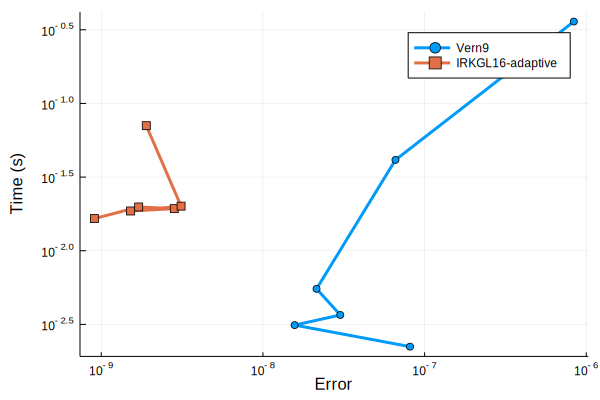

In [18]:
setups = [
           Dict(:alg=>Vern9())
           Dict(:alg=>IRKGL16(),:adaptive=>true,:mixed_precision=>false) 
]
solnames = ["Vern9","IRKGL16-adaptive"]
wp1 = WorkPrecisionSet(prob64,abstols,reltols,setups;appxsol=test_sol,names=solnames,
                       save_everystep=false,numruns=10,maxiters=10^9);

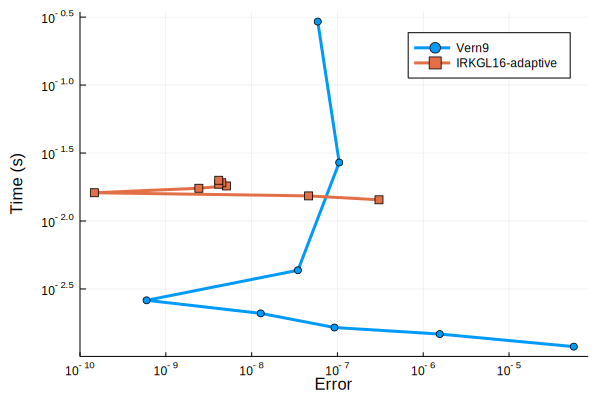

In [3]:
plot(wp1)

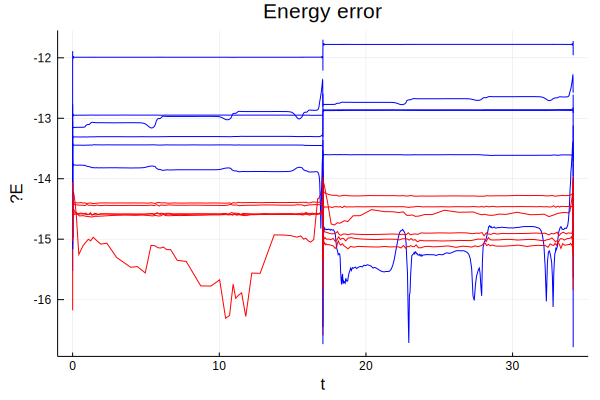

In [19]:
pl=plot(title="Energy error", xlabel="t", ylabel="ΔE")
maxE1=[]
maxE9=[]
for k in 1:length(abstols)
    sol9=solve(prob64,Vern9(),abstol=abstols[k],reltol=reltols[k])
    ΔE9 = map(x->RTBPEnergy(BigFloat.(x),μ256), sol9.u)./E0.-1
    sol1= solve(prob64,IRKGL16(),abstol=abstols[k],reltol=reltols[k]);
    ΔE1 = map(x->RTBPEnergy(BigFloat.(x),μ256), sol1.u)./E0.-1
    pl=plot!(sol9.t,log10.(abs.(ΔE9)), label="", color="blue")
    pl=plot!(sol1.t,log10.(abs.(ΔE1)), label="", color="red")
    push!(maxE1,maximum(log10.(abs.(ΔE1))))
    push!(maxE9,maximum(log10.(abs.(ΔE9))))
end
plot(pl)

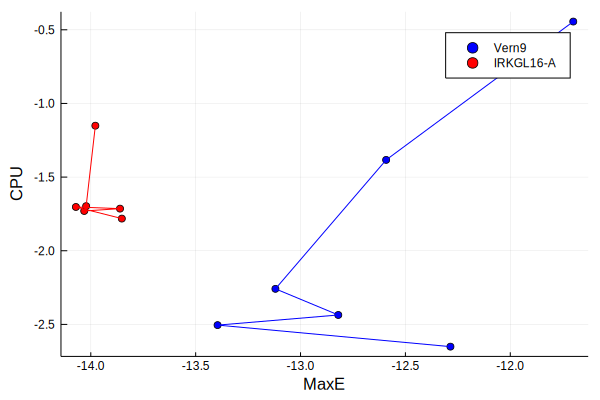

In [20]:
plot(xlabel="MaxE", ylabel="CPU")
plot!(maxE9,log10.(wp1[1].times), seriestype=:scatter,label="Vern9", color="blue")
plot!(maxE9,log10.(wp1[1].times), label="",color="blue")
plot!(maxE1,log10.(wp1[2].times),seriestype=:scatter, label="IRKGL16-A",color="red")
plot!(maxE1,log10.(wp1[2].times), label="",color="red")

<a href="#top">Back to the top</a>

## Work-Precision diagrams (Float128)

In [28]:
setprecision(BigFloat, 108)
abstols = 1.0 ./ 10.0 .^ (12:30)
reltols = 1.0 ./ 10.0 .^ (12:30);

### Float128 (OdeProblem)

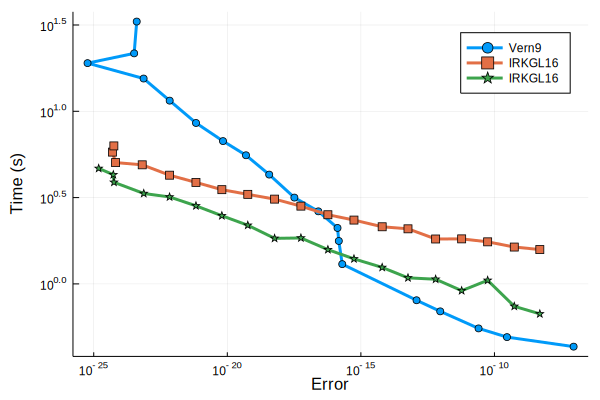

In [29]:
setups = [ Dict(:alg=>Vern9())
           Dict(:alg=>IRKGL16(),:adaptive=>true,:mixed_precision=>false) 
           Dict(:alg=>IRKGL16(),:adaptive=>true,:mixed_precision=>true,:low_prec_type=>Float64)
           Dict(:alg=>IRKGL16(),:adaptive=>true,:mixed_precision=>true,:low_prec_type=>Float64,:threading=>true)
]
solnames = ["Vern9","IRKGL16-adaptive","IRKGL16-adaptive/Mix","IRKGL16-adaptative/Mix/thread"]
wp2 = WorkPrecisionSet(prob128,abstols,reltols,setups;appxsol=test_sol,save_everystep=false,
                        names=solnames,numruns=10,maxiters=10^9);

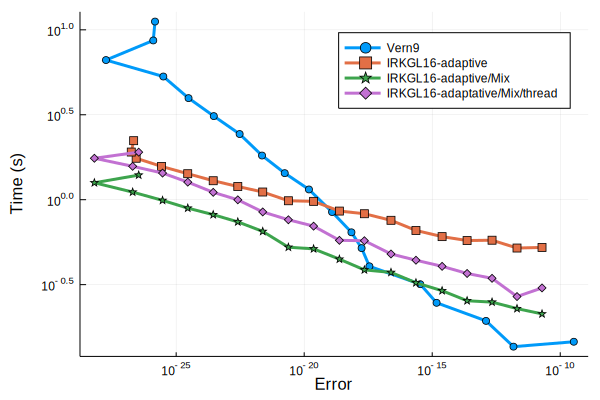

In [6]:
plot(wp2)

In [4]:
wp2=wp11

WorkPrecisionSet of 4 wps


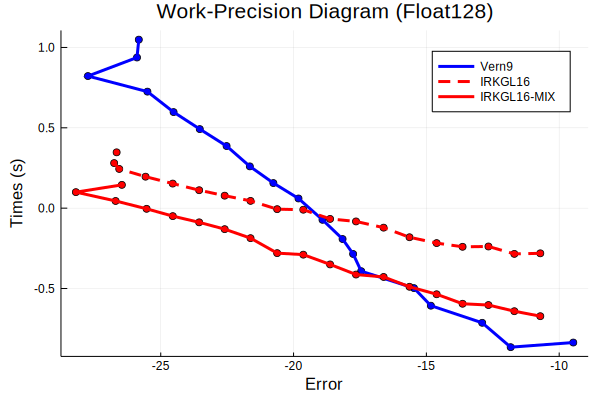

In [5]:
plot(title="Work-Precision Diagram (Float128)", xlabel="Error", ylabel="Times (s)")
k=1
plot!(log10.(wp2.wps[k].errors),log10.(wp2.wps[k].times), seriestype=:scatter, label="", color="blue")
plot!(log10.(wp2.wps[k].errors),log10.(wp2.wps[k].times), label="Vern9", color="blue", lw=3)
# 
k=2
plot!(log10.(wp2.wps[k].errors),log10.(wp2.wps[k].times), seriestype=:scatter, label="", color="red")
plot!(log10.(wp2.wps[k].errors),log10.(wp2.wps[k].times), label="IRKGL16", color="red", lw=3, linestyle=:dash)
#
k=3
plot!(log10.(wp2.wps[k].errors),log10.(wp2.wps[k].times), seriestype=:scatter, label="",color="red")
plot!(log10.(wp2.wps[k].errors),log10.(wp2.wps[k].times), label="IRKGL16-MIX",color="red", lw=3)

### Save Data

In [ ]:
@save "./Data/output/OutRTBP_wp1.jld2" wp1
@save "./Data/output/OutRTBP_wp2.jld2" wp2

In [2]:
@load "./Data/output/OutRTBP_wp1.jld2" wp1
@load "./Data/output/OutRTBP_wp2.jld2" wp11

┌ Warning: read type ODEFunction{true,var"#3#4",UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing} has a different number of parameters from type ODEFunction in workspace; reconstructing
└ @ JLD2 /home/joseba/.julia/packages/JLD2/2W9VX/src/data.jl:1152
┌ Warning: read type ODEFunction{true,var"#3#4",UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing} has a different number of parameters from type ODEFunction in workspace; reconstructing
└ @ JLD2 /home/joseba/.julia/packages/JLD2/2W9VX/src/data.jl:1152


1-element Array{Symbol,1}:
 :wp11

<a href="#top">Back to the top</a>